In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Activation, Add
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt



In [ ]:

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train.reshape(-1, 784).astype('float32') / 255.0
x_test = x_test.reshape(-1, 784).astype('float32') / 255.0
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)



In [ ]:
early_stop = EarlyStopping(patience=6, restore_best_weights=True)


lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=2000,
    decay_rate=0.9
)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9, nesterov=True)
loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)


In [ ]:
def create_dnn():
    inputs = Input(shape=(784,))
    x = BatchNormalization()(inputs)

    
    taper_units = [512]*6 + [384]*5 + [256]*5 + [128]*4 + [96]*3 + [64]*2 + [48]*5 + [32]*5 + [24]*5 + [16]*5

    for units in taper_units:
        x = Dense(units, kernel_initializer='he_normal')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Dropout(0.2)(x)

    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(10, activation='softmax')(x)

    return Model(inputs, outputs)


In [ ]:
def residual_block(x, units):
    shortcut = x

    x = Dense(units, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)

    x = Dense(units, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)

    if x.shape[-1] != shortcut.shape[-1]:
        shortcut = Dense(units, kernel_initializer='he_normal')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def create_resnet():
    inputs = Input(shape=(784,))
    x = BatchNormalization()(inputs)
    x = Dense(512, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

  
    taper_units = [512]*6 + [384]*5 + [256]*5 + [128]*4 + [96]*3 + [64]*2

    for units in taper_units:
        x = residual_block(x, units)

    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(10, activation='softmax')(x)

    return Model(inputs, outputs)


In [ ]:
dnn_model = create_dnn()
dnn_model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

resnet_model = create_resnet()
resnet_model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])




In [7]:
dnn_history = dnn_model.fit(x_train, y_train, epochs=50, batch_size=128,
                            validation_split=0.1, callbacks=[early_stop], verbose=1)


Epoch 1/50
422/422 [==============================] - 68s 75ms/step - loss: 2.3084 - accuracy: 0.1112 - val_loss: 2.2963 - val_accuracy: 0.1093
Epoch 2/50
422/422 [==============================] - 26s 62ms/step - loss: 2.2415 - accuracy: 0.1405 - val_loss: 2.3076 - val_accuracy: 0.1003
Epoch 3/50
422/422 [==============================] - 27s 64ms/step - loss: 2.2031 - accuracy: 0.1550 - val_loss: 2.3101 - val_accuracy: 0.1097
Epoch 4/50
422/422 [==============================] - 26s 63ms/step - loss: 2.1711 - accuracy: 0.1703 - val_loss: 2.3465 - val_accuracy: 0.0942
Epoch 5/50
422/422 [==============================] - 26s 61ms/step - loss: 2.1392 - accuracy: 0.1797 - val_loss: 2.3339 - val_accuracy: 0.1025
Epoch 6/50
422/422 [==============================] - 26s 62ms/step - loss: 2.1118 - accuracy: 0.1858 - val_loss: 2.2051 - val_accuracy: 0.1598
Epoch 7/50
422/422 [==============================] - 26s 62ms/step - loss: 2.0838 - accuracy: 0.1830 - val_loss: 2.1445 - val_accuracy:

In [8]:
resnet_history = resnet_model.fit(x_train, y_train, epochs=50, batch_size=128,
                                  validation_split=0.1, callbacks=[early_stop], verbose=1)


Epoch 1/50
422/422 [==============================] - 70s 82ms/step - loss: 1.8896 - accuracy: 0.3432 - val_loss: 1.2486 - val_accuracy: 0.6483
Epoch 2/50
422/422 [==============================] - 31s 73ms/step - loss: 1.2533 - accuracy: 0.6505 - val_loss: 1.0733 - val_accuracy: 0.7118
Epoch 3/50
422/422 [==============================] - 32s 75ms/step - loss: 1.1416 - accuracy: 0.6990 - val_loss: 1.0131 - val_accuracy: 0.7425
Epoch 4/50
422/422 [==============================] - 32s 75ms/step - loss: 1.0856 - accuracy: 0.7250 - val_loss: 0.9760 - val_accuracy: 0.7578
Epoch 5/50
422/422 [==============================] - 34s 80ms/step - loss: 1.0501 - accuracy: 0.7434 - val_loss: 0.9524 - val_accuracy: 0.7845
Epoch 6/50
422/422 [==============================] - 33s 79ms/step - loss: 1.0113 - accuracy: 0.7696 - val_loss: 0.9133 - val_accuracy: 0.8025
Epoch 7/50
422/422 [==============================] - 33s 77ms/step - loss: 0.9802 - accuracy: 0.7892 - val_loss: 0.8906 - val_accuracy:

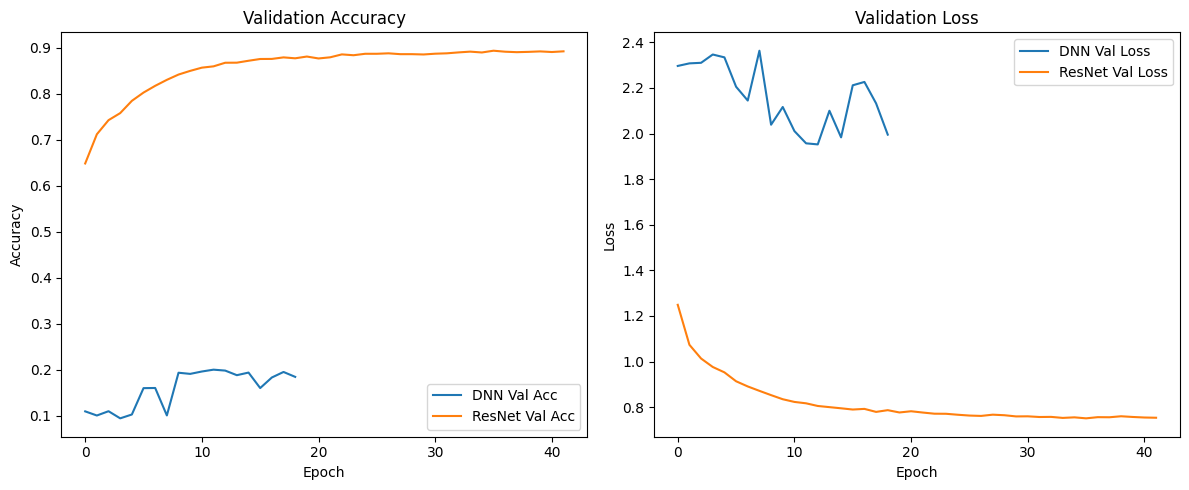

In [9]:
def plot_history(hist1, hist2, name1='DNN', name2='ResNet'):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(hist1.history['val_accuracy'], label=f'{name1} Val Acc')
    plt.plot(hist2.history['val_accuracy'], label=f'{name2} Val Acc')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(hist1.history['val_loss'], label=f'{name1} Val Loss')
    plt.plot(hist2.history['val_loss'], label=f'{name2} Val Loss')
    plt.title('Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(dnn_history, resnet_history)


In [11]:
print("DNN Final Test Accuracy:")
dnn_model.evaluate(x_test, y_test)

print("ResNet Final Test Accuracy:")
resnet_model.evaluate(x_test, y_test)


DNN Final Test Accuracy:
313/313 [==============================] - 5s 15ms/step - loss: 1.9463 - accuracy: 0.2000
ResNet Final Test Accuracy:
313/313 [==============================] - 6s 19ms/step - loss: 0.7676 - accuracy: 0.8848


[0.7676461935043335, 0.8848000168800354]